# Store Full Time-Evolving Catalog As Dictionary of Data Frames 
Each entry will have `pandas` data frames for the chain samples, meta data, and waveform reconstructions
The data frames are built from arbitrary lists of observing times `<T>` and analysis segments, assuming run directories are named like `<T>/seg<ID number>`

In [1]:
import h5py
import glob
import tables
import numpy as np
import pandas as pd
import pydot
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer
import warnings

#silence some warnings when writing to hdf5
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


In [2]:
# Initialize catalog dictionary, and set time-frequency range to cover

catalogFileName = 'ucb_catalog.h5'
catalog = {} #the dictionary holding all catalog data products

# list of observing times to include in dictionary
# Assume that these match top-level directory names for runs
time_list = ['1.5mo','03mo','06mo','12mo','24mo'] 

# dictionary of frequency segments identified by serial numbers from runs
# The ID numbers for the run directories in each observing time do not need to be identical.
segment_list = {} 
segment_list["1.5mo"]=['440','441','442']
segment_list["03mo"]=['440','441','442']
segment_list["06mo"]=['440','441','442']
segment_list["12mo"]=['440','441','442']
segment_list["24mo"]=['440_0','441_0','442_0','440_1','441_1','442_1'] 

parameters = ['f','fdot','amp','lon','coslat','cosinc','psi','phi'] # column header for parameter files
chain_columns = ['f','fdot','amp','lon','coslat','cosinc','psi','phi','match'] # column header for chain files

### Get list of detections
Scans through `<T>/seg<ID number>` directories and extract contents of all `catalog_N` directories and combines the `entries` data (including event ID `name`, SNR of reference waveform `snr`, and detection confidence `evidence` with referenc parameters for each source.

**This will break if there are multiple `catalog_N` directories within each segment directory**


In [3]:
# parse catalog entries files into meta-data frame listing entries

entries = [] # place-holder for data frames to be concatenated 

for T in time_list:
    
    fd_t = [] # list of all data frames built from analysis segments for a given observing time T
    
    for seg in segment_list[T]:
        
        dir=T + "/" + "seg" + seg + "/catalog_*/" #path to the GBMCMC catalog data products
        
        entry_files = glob.glob(dir + "entries.dat") #file containing the list of detections
        
        for f in entry_files:
            
            # parse entry files
            fd = pd.read_table(f,delimiter=" ",header=None,names=['name','snr','evidence'],index_col=False)

            # parse event reference parameter files <path>/<GW ID>_params.dat
            pe=[] # list of data frames containing parameters for each detection
            
            names = fd['name'].tolist()
            for name in names:
                paramfile = glob.glob(dir+name+"_params.dat")
                for f in paramfile:
                    pe.append(pd.read_table(f,delimiter=" ",header=None,index_col=False,names=parameters))
            
            # combine parameter data frames into one table
            pedf=pd.concat(pe)
            
            # convert to numpy array so it can easily be combined with the already-made entry data frame
            for p in parameters:
                fd[p] = pedf[p].to_numpy()               
            fd_t.append(fd)
            
    # combine data frames for each analysis segment, keyed by seg ID
    entries.append(pd.concat(fd_t,keys=segment_list[T]))

#concatenate segment dataframes from each T into single frame    
detections = pd.concat(entries,keys=time_list,axis=1)

#write detections data frame to HDF5
detections.to_hdf(catalogFileName, key='detections', mode='w')

#store detections data frames in the catalog dictionary entry
catalog["detections"] = detections


In [4]:
# examples of how to pull out parts of the data frame

# display the whole dataframe
#catalog["detections"].head()

# display table of detection and SNR 
# for the 12 mo run on segment 440
#catalog["detections"]['12mo'][['name','snr','amp']].loc['440'] 

# plot point estimates of sky location from 24 mo run
#catalog["detections"]["24mo"].plot(kind="scatter",x="lon",y="coslat")


### Build data frame for posterior samples.
 
Use `detections` data frame to parse post-processed results MCMC results.
From this add posterior samples to `catalog` dictionary in the `samples` key.
The `samples` value is a nested dictionary of data frames containing the posterior samples for each detection.
The key for the different data frames is `Tobs` and the values are the posterior samples data frames.
The `samples` data frames have keys for the GW `name`.

In [5]:

names = [] #list of detections
catalog["samples"]={} # dictionary of posterior samples keyed by observation time

#loop over all time segments
for T in time_list:

    data_frame_list = [] # list of chain data frames
    catalog["samples"][T] = {} # nested dictionary will keep sample data frames as values keyed by event ID

    #loop over all frequency segments
    for seg in segment_list[T]:
        
        #get number of detections in time-frequency segment
        ndet = catalog["detections"][T]['name'].loc[seg].size

        #loop over all detections
        for n in range(0,ndet):
            
            #pull out event name from dataframe
            name = catalog["detections"][T]['name'].loc[seg][n]

            #pandas puts nans in empty cells
            #if the cell is not empty...
            if name==name:
                
                #keep list of detections
                names.append(name)
                
                #get path to chain file
                chainfile = glob.glob(T + "/" + "seg" + seg + "/catalog_*/"+name+"_chain.dat")
                
                #load chainfile into dataframe
                for f in chainfile:
                    samples = pd.read_table(f,delimiter=" ",header=None,names=chain_columns,index_col=None)
                    samples.to_hdf(catalogFileName, key=name)
                    catalog["samples"][T][name] = samples
                    


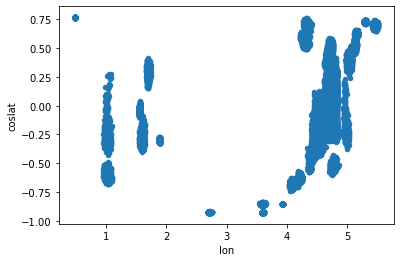

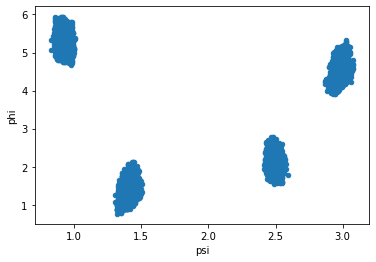

In [6]:
# display all chain samples for T = 12mo
name = catalog["detections"]["12mo"]['name'].loc["442"]
catalog["samples"]["12mo"]

# scatter plot of sky location for all detections
fd = pd.concat(catalog["samples"]["24mo"])
fd.plot(kind="scatter",x='lon',y='coslat')

# scatter plot of chain samples in polarization/phase plane
# for two particular detections from T=12mo run

# list of detectsion in 12mo catalog 
name = catalog["detections"]["12mo"]['name']

#alias to the samples dictionary
samples_12mo = catalog["samples"]["12mo"]

fd = pd.concat([samples_12mo[name[0]],samples_12mo[name[1]]])
fd.plot(kind="scatter",x='psi',y='phi')

## Read in ancestry of each source and store in data frame
Each `catalog_N` directory contains a file matching the `parent` source from the previous catalog to the `child` source in the current catalog.  

In [7]:

history = [] # list of parent-child data frames

#loop over all time segments
for T in time_list[1:]:

    hd_t = [] #concatenated list of frames at each observing epoch

    #loop over all frequency segments
    for seg in segment_list[T]:

        history_files = glob.glob(T + "/" + "seg" + seg + "/catalog_*/" + "history.dat")
                
        for f in history_files:
            hd = pd.read_table(f,delimiter=" ",header=None,names=['parent','child'],index_col=False)

        hd_t.append(hd)
    history.append(pd.concat(hd_t))

#concatenate segment dataframes from each Tobs into single frame    
lineage = pd.concat(history,keys=time_list,ignore_index=True)

#write lineage data frame to HDF5
lineage.to_hdf(catalogFileName, key='lineage')

#store lineage data frames in the catalog dictionary entry
catalog["lineage"] = pd.concat(history,keys=time_list[1:])

#print(catalog["lineage"])

In [8]:
history = [] # place-holder for data frames to be concatenated

#loop over all time segments
for T in time_list[1:]:
    
    hd_t = [] # list of history data frames

    #loop over all frequency segments
    for seg in segment_list[T]:

        dir=T + "/" + "seg" + seg + "/catalog_*/"
        history_files = glob.glob(dir + "history.dat")
                
        for f in history_files:
            hd = pd.read_table(f,delimiter=" ",header=None,names=['parent','child'],index_col=False)

        hd_t.append(hd)

    history.append(pd.concat(hd_t,ignore_index=True))

#concatenate history dataframes from each Tobs into single frame    
lineage = pd.concat(history,keys=time_list[1:])

#write lineage data frame to HDF5
lineage.to_hdf(catalogFileName, key='lineage')

#store lineage data frames in the catalog dictionary entry
catalog["lineage"] = lineage


## Create dictionary with data frames from HDF5 file

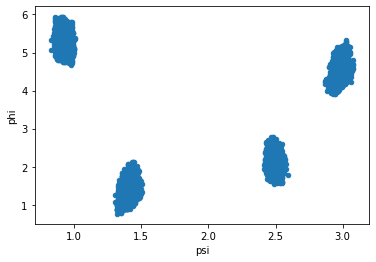

In [9]:
# load hdf5 file into same format
catalog_from_file = {}
catalog_from_file["detections"] = pd.read_hdf(catalogFileName, 'detections')
catalog_from_file["lineage"] = pd.read_hdf(catalogFileName, 'lineage')
catalog_from_file["samples"]={}
for T in time_list:
    catalog_from_file["samples"][T] = {}
    names = catalog_from_file["detections"]["12mo"]['name']
    for name in names:
        if name==name:
            catalog_from_file["samples"][T] = pd.read_hdf(catalogFileName,name)

# test by comparing plots
samples = catalog["samples"]["12mo"]
name = catalog["detections"]["12mo"]['name']

fd = pd.concat([samples[name[0]],samples[name[1]]])
fd.plot(kind="scatter",x='psi',y='phi')



# Let's get wild and try some corner plots

## Joint posterior for all detections for one Tobs

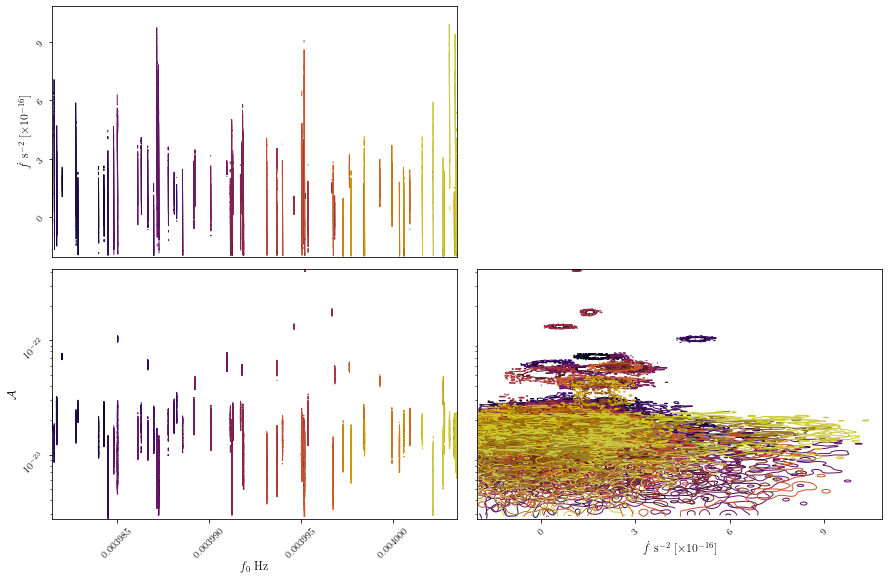

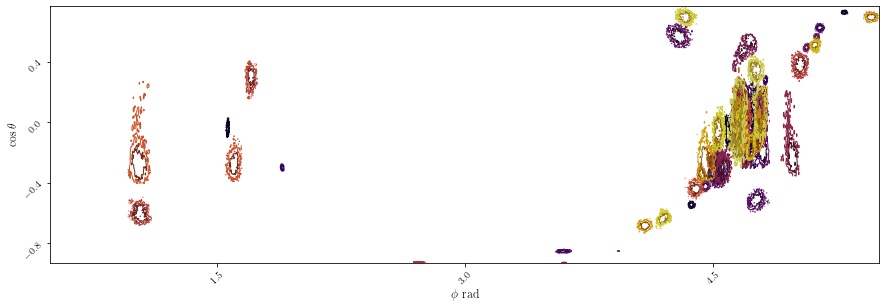

In [10]:
c = ChainConsumer()

# aliases to the samples dictionary of data frames & the list of event IDs
T='24mo'
samples = catalog["samples"][T]
names = catalog["detections"][T]['name']

# pretty format for parameter names
params=[r'$f_0\ \rm{Hz}$', 
             r'$\dot f\ \rm{s}^{-2}$', 
             r'$\mathcal A$', 
             r'$\phi\ \rm{rad}$',  
             r'$\cos\theta$', 
             r'$\cos\iota$', 
             r'$\psi\ \rm{rad}$',
             r'$\phi\ \rm{rad}$',
             r'$\mathcal M$']

# chain consumer wants numpy arrays, so reformat samples data frames
for name in names:
    chain = []
    if name == name:
        chain = samples[name].to_numpy()
        c.add_chain(chain,parameters=params,name=' ')
        
# chain consumer voodoo
c.configure(plot_hists=False)
xsize = 2*2*3.39
ysize = 2*3.39*(np.sqrt(5)-1.0)/2.0

#plot intrinsic parameters
fig = c.plotter.plot(parameters=[params[0],params[1],params[2]],figsize=[xsize,2*ysize],log_scales=params[2])

#plot sky location
fig = c.plotter.plot(parameters=[params[3],params[4]],figsize=[xsize,ysize])

## Compare time-evolving solution for one of the loudest binaries
This demonstration selects a binary by hand to track over observing times.
**TODO:** use `lineage` data frames to automatically trace through a source.

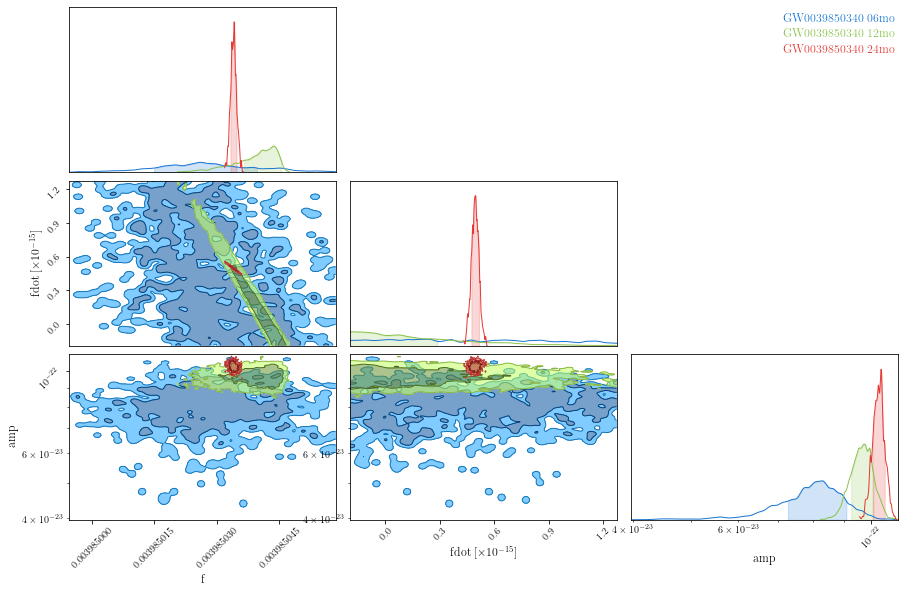

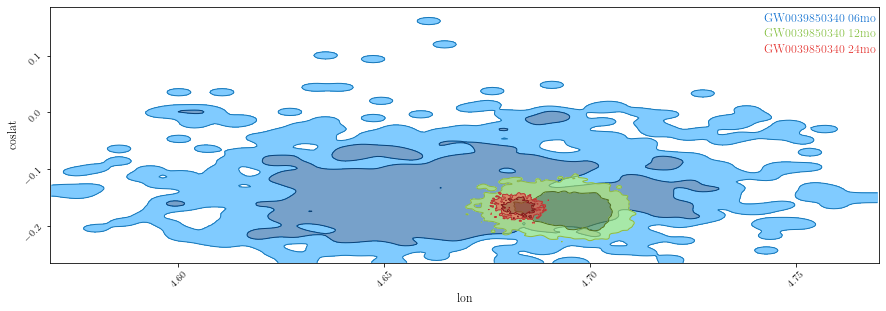

In [11]:
# grab by hand one of the louder detections
loud = {'06mo':'GW0039850270','12mo':'GW0039850402','24mo':'GW0039850340'}

c = ChainConsumer()


# reformat & load chain files

for T in ['06mo','12mo','24mo']:
    name = loud["24mo"]+' '+T
    chain=catalog["samples"][T][loud[T]].to_numpy()
    c.add_chain(chain,parameters=chain_columns,name=name)
    
# chain consumer voodoo
xsize = 2*2*3.39
ysize = 2*3.39*(np.sqrt(5)-1.0)/2.0

#plot intrinsic parameters
fig = c.plotter.plot(parameters=[chain_columns[0],chain_columns[1],chain_columns[2]],figsize=[xsize,2*ysize],log_scales=chain_columns[2])

#plot sky location
c.configure(plot_hists=False)
fig = c.plotter.plot(parameters=[chain_columns[3],chain_columns[4]],figsize=[xsize,ysize])

## Create graph of source identification as it evolves with observing time

Use `pydot` to produce a `dot` graph connecting identified sources between time-stamps of the catalog.
The graph is constructed from a list of _nodes_ (each entry in the catalog) and _edges_ , or connections between nodes, made of lists of pairs of nodes constructed from the `lineage` entry in the `catalog` dictionary.

The graph is constructed from sets of _clusters_ of nodes built from all of the entries for a particular observing time. This keeps the layers of the nodes in the graph together for different generations of the catalog.

Nodes are color-coded: Green nodes are new entries to the catalog, and white nodes are entries with clearly identified ancestors.

**TODO:** color-code events dropped from the catalog (i.e. no children)

**TODO:** color-code events that split/merge (i.e. multiple parents/children)

**TODO:** graph is confused when a source has _identical_ names in two epochs

In [12]:
# the pydot graph 
tree = pydot.Dot(graph_type='graph',rankdir='LR',ranksep=4,splines='ortho')
tree.set_node_defaults(color='black',
                            style='filled',
                            fillcolor='lightgray',
                            shape='box',
                            fontname='Courier',
                            fontsize='12',
                            showboxes='black')


# graph nodes stored in a dictionary keyed by observing time
nodes={}
    
    
    
#add all of the first catalog as new events
T=time_list[0]
nodes[T]={}

#loop over all frequency segments
for seg in segment_list[T]:
        
    #get number of detections in time-frequency segment
    ndet = catalog["detections"][T]['name'].loc[seg].size
        
    #loop over all detections
    for n in range(0,ndet):
            
        #pull out event name from dataframe
        name = catalog["detections"][T]['name'].loc[seg][n]
            
        #pandas puts nans in empty cells
        #if the cell is not empty...
        if name==name:
            #add node and mark as a new source
            nodes[T][name]=pydot.Node(name)  
            nodes[T][name].set_fillcolor('#b3e2cd')
            nodes[T][name].set_color('#1b9e77')

            
            
#loop over remaining time segments
for T in time_list[1:]:

    nodes[T]={}

    #loop over all frequency segments
    for seg in segment_list[T]:
        
        #get number of detections in time-frequency segment
        ndet = catalog["detections"][T]['name'].loc[seg].size
        
        #loop over all detections
        for n in range(0,ndet):
            
            #pull out event name from dataframe
            name = catalog["detections"][T]['name'].loc[seg][n]
            
            #pandas puts nans in empty cells
            #if the cell is not empty...
            if name==name:
                #add node
                nodes[T][name]=pydot.Node(name)  
                        
                #get list of sources in current T that have known parents    
                kids = catalog["lineage"]['child'].loc[T]
                freq = kids.value_counts()
                
                #if source does not have a parent...
                if name not in kids.values: 
                    #mark as a new source
                    nodes[T][name].set_fillcolor('#b3e2cd')
                    nodes[T][name].set_color('#1b9e77')

                else:
                    nodes[T][name].set_fillcolor('white')
                 
                #here we'll highlight cases where a source splits or merges between generations
                #if len(catalog["lineage"].loc[T][catalog["lineage"].loc[T].parent == name]) > 1:
                    
    

# cluster nodes based on observing time, and label cluster
for T in time_list:
    cluster=pydot.Cluster(T,label=T,color='white',fontsize=32)
    for node in nodes[T]:
        cluster.add_node(nodes[T][node])
    tree.add_subgraph(cluster)    

# add edges to graph between parent & child nodes
edges = {}    
ntimes = len(time_list)

# skip the first generation of the catalog (no parents)
for n in range(1,ntimes):
    
    # child nodes come from current epoch T, parent nodes are stored in the previous epoch Tm
    T = time_list[n]
    Tm = time_list[n-1]
    
    edges[T]={}
        
    #get number of parents in time-frequency segment = number of incoming edges to this generation
    nparent = catalog["lineage"]['parent'].loc[T].size
        
    #loop over all parents
    for p in range(0,nparent):
        
        #pull out event names from dataframe
        parent = catalog["lineage"]['parent'].loc[T][p]
        child  = catalog["lineage"]['child'].loc[T][p]
                
        #map parent in this epoch to node in previous epoch, and add edge connecting with current source
        if parent==parent:                
            edges[T][parent]=pydot.Edge(nodes[Tm][parent],nodes[T][child])
            tree.add_edge(edges[T][parent])

#we made it!
tree.write_png('ucb_catalog_tree.png')
